In [1]:
import pandas as pd
%reload_ext watermark
%matplotlib inline

from contextlib import suppress
from datetime import datetime
import os
import yaml

from metapool.metapool import *
from metapool import (make_sample_sheet, find_threshold, autopool)
from metapool.mp_strings import (PM_LIB_WELL_KEY, PM_COMPRESSED_PLATE_NAME_KEY,
    MINIPICO_LIB_CONC_KEY, TELLSEQ_BARCODE_SET_ID_KEY, TELLSEQ_BARCODE_ID_KEY)
from metapool.sample_sheet import (
    TELLSEQ_METAG_SHEET_TYPE, TELLSEQ_ABSQUANT_SHEET_TYPE, make_sections_dict)
from metapool.util import get_set_fp, warn_if_fp_exists
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-12-04T16:59:50.743830-08:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.12.0

metapool    : 0+untagged.221.gd899203
sample_sheet: 0.13.0
openpyxl    : 3.1.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Hostname: C02G21EEMD6Q

matplotlib: 3.9.0
pandas    : 2.2.2
yaml      : 6.0.1
seaborn   : 0.13.2
json      : 2.0.9
numpy     : 2.0.0
re        : 2.2.1



In [2]:
! conda list

# packages in environment at /Applications/miniconda3/envs/metapool:
#
# Name                    Version                   Build  Channel
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hdc70f33_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
biom-format               2.1.16                   pypi_0  

# Knight Lab TellSeq pipeline notebook C

## Part 4 (of 5): Workflow for normalizing DNA

This portion of the notebook will construct an Echo normalization picklist file for the selected barcode set.

As inputs, it requires:
1. A tab-delimited `*_plate_df_A.txt` file containing the quantitations for the entire 384-well plate
2. A yaml file containing the experiment name and info on the included studies

The workflow then:
1. reads in the specified input files
2. calculates the pooling volumes for the samples in the selected barcode set
3. produces an Echo-formatted pick list file for that set
4. produces a tab-delimited `*_plate_df_C_set_*.txt` file containing the plate df for (only) the samples in this barcode set 

### Step 1 of 7: Read in the 384-well plate data and the experiment info

In [3]:
## INPUT
full_plate_fp = './test_output/QC/Tellseq_plate_df_B.txt'
expt_config_fp = './test_output/QC/Tellseq_expt_info.yml'

In [4]:
# if the full_plate_fp does not end with "plate_df_B.txt", throw an error
expected_suffix = f"plate_df_B.txt"
if not full_plate_fp.endswith(expected_suffix):
    raise ValueError(f"Expected file ending with '{expected_suffix}'")

In [5]:
for curr_fp in [full_plate_fp, expt_config_fp]:
    if not os.path.isfile(curr_fp):
        print("Problem! %s is not a path to a valid file" % curr_fp)

In [6]:
full_plate_df = pd.read_csv(full_plate_fp, sep='\t')
full_plate_df.head()

,Unnamed: 0,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,...,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,sample sheet Sample_ID
0,0,0,01LJ00482.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col1to6,C501,0.612,1.854545,7.495680,01LJ00482_V5
1,1,192,01LJ01100.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col1to6,C509,0.623,1.887879,7.502390,01LJ01100_V5
2,2,12,01LJ01597.V8,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col1to6,C502,0.632,1.915152,7.502735,01LJ01597_V8
3,3,204,01LJ01315.V5,1,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col1to6,C510,0.606,1.836364,7.494064,01LJ01315_V5
4,4,24,01LJ02862.V5,1,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col1to6,C503,1.001,3.033333,7.503163,01LJ02862_V5


In [7]:
is_absquant(full_plate_df)

False

In [8]:
with open(expt_config_fp, 'r') as f:
    expt_config = yaml.safe_load(f)

In [9]:
expt_name = expt_config['experiment_name']
expt_name

'RKLtest'

In [10]:
full_studies_info = expt_config['studies']
full_studies_info

[{'Email': 'r@gmail.com',
  'HumanFiltering': 'True',
  'Project Abbreviation': 'WellcomeLeap',
  'Project Name': 'Wellcome_Leap_15538',
  'experiment_design_description': 'plasma sequencing',
  'qiita_id': '15538',
  'qiita_metadata_fp': './test_data/Plate_Maps/15538_20241004-110731.txt',
  'sample_accession_fp': './test_data/Plate_Maps/Tellseq_Wellcome Leap - 15538 - Sample Accession.csv'}]

In [11]:
set_ids = full_plate_df[TELLSEQ_BARCODE_SET_ID_KEY].unique()
set_ids

array(['col1to6', 'col7to12', 'col13to18', 'col19to24'], dtype=object)

### Step 2 of 7: Select the barcode set

Select the barcode set to process in this notebook and set it below.

In [12]:
## INPUT
current_set_id = "col19to24"

In [13]:
plate_df = full_plate_df[full_plate_df[TELLSEQ_BARCODE_SET_ID_KEY] == current_set_id].copy()
plate_df.shape

(96, 48)

In [14]:
plate_df.head()

,Unnamed: 0,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,...,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,sample sheet Sample_ID
288,288,9,01LJ01593.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,C501,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col19to24,C501,0.635,1.924242,7.496689,01LJ01593_V8
289,289,201,01LJ01300.V5,10,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,C509,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col19to24,C509,5.113,15.493939,7.496200,01LJ01300_V5
290,290,21,01LJ02603.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,C502,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col19to24,C502,0.677,2.051515,7.507742,01LJ02603_V8
291,291,213,01LJ01344.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_2to1dilution,...,C510,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col19to24,C510,1.047,3.172727,7.499745,01LJ01344_V5
292,292,33,01LJ04170.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,C503,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col19to24,C503,3.777,11.445455,7.495723,01LJ04170_V5


Verify that there are no duplicate barcodes in the selected plate df.  This must return True.

In [15]:
## DECISION -- verify no duplicate barcodes
plate_df[TELLSEQ_BARCODE_ID_KEY].value_counts().nunique() == 1

True

In [16]:
row_col_key = f"{PM_LIB_WELL_KEY}_row"
col_col_key = f"{PM_LIB_WELL_KEY}_col"

In [17]:
source_well_names = make_compressed_2d_array(
    plate_df, data_col=PM_LIB_WELL_KEY, 
    row_col=row_col_key, col_col=col_col_key)
source_well_names

array([['A19', 'A20', 'A21', 'A22', 'A23', 'A24'],
       ['B19', 'B20', 'B21', 'B22', 'B23', 'B24'],
       ['C19', 'C20', 'C21', 'C22', 'C23', 'C24'],
       ['D19', 'D20', 'D21', 'D22', 'D23', 'D24'],
       ['E19', 'E20', 'E21', 'E22', 'E23', 'E24'],
       ['F19', 'F20', 'F21', 'F22', 'F23', 'F24'],
       ['G19', 'G20', 'G21', 'G22', 'G23', 'G24'],
       ['H19', 'H20', 'H21', 'H22', 'H23', 'H24'],
       ['I19', 'I20', 'I21', 'I22', 'I23', 'I24'],
       ['J19', 'J20', 'J21', 'J22', 'J23', 'J24'],
       ['K19', 'K20', 'K21', 'K22', 'K23', 'K24'],
       ['L19', 'L20', 'L21', 'L22', 'L23', 'L24'],
       ['M19', 'M20', 'M21', 'M22', 'M23', 'M24'],
       ['N19', 'N20', 'N21', 'N22', 'N23', 'N24'],
       ['O19', 'O20', 'O21', 'O22', 'O23', 'O24'],
       ['P19', 'P20', 'P21', 'P22', 'P23', 'P24']], dtype=object)

In [18]:
unique_projects = plate_df[PM_PROJECT_NAME_KEY].unique()
studies_info = []
for a_study in full_studies_info:
    if a_study[PM_PROJECT_NAME_KEY] in unique_projects:
        studies_info.append(a_study)
studies_info

[{'Email': 'r@gmail.com',
  'HumanFiltering': 'True',
  'Project Abbreviation': 'WellcomeLeap',
  'Project Name': 'Wellcome_Leap_15538',
  'experiment_design_description': 'plasma sequencing',
  'qiita_id': '15538',
  'qiita_metadata_fp': './test_data/Plate_Maps/15538_20241004-110731.txt',
  'sample_accession_fp': './test_data/Plate_Maps/Tellseq_Wellcome Leap - 15538 - Sample Accession.csv'}]

### Step 3 of 7: Calculate pooling values for MiniPico with autopool

This step will calculate the sample pooling, and update the sample data frame with the pool info.
There are two automated methods to pool:
1. **norm**: This will attempt to generate a normalized pool, automatically inferring the best parameter for pooling.
    - ***pool_failures***:
        - _high_: will pool failures at the highest pooling volume from optimized pooling.
        - _low_: will pool failures at the lowest pooling volume from optimized pooling.

2. **evp**: This will pool an even volume per sample.
    - ***total_vol***: (Optional, Default: 100µL) The total volume to pool, in uL. Each sample will be pooled at 1/N of that volume, where N is total number of samples in the prep.

3. **automate**: (Optional, Default = True) When False, this argument will allow one input parameters for **Legacy** arguments. 

> **Legacy**
> There are legacy parameters to control pooling behaviors when autopool automation (automate=True) returns a poor result. To use these parameters, one must pass automate=False.

>   - **min_conc**: (default: 0) This is the minimum concentration for a sample to be considered for pooling.
    Set to 0 to pool all samples, regardless of concentration. Increasing this will have the 
    effect of increasing pool concentration, at the expense of samples dropping out. 
>   - **floor_conc**: This is the lowest concentration equivalent for which a sample will be 
    accurately pooled. Samples below this concentration will be pooled to the volume that they 
    would have been if they were actually that concentration. For example, if `floor_conc=20`, 
    and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 
    10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect 
    of increasing pool concentration, but decreasing read counts for low-concentration samples. 
>   - **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing
    this will increase the overall volume of the pool.


In [19]:
## INPUT -- verify default
total_vol = 190

In [20]:
plate_df = autopool(plate_df,method='evp',total_vol=total_vol)
plate_df.head()

,Unnamed: 0,index,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,...,i5 plate,i5 well_row,i5 well_col,barcode_set_id,barcode_id,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,sample sheet Sample_ID,MiniPico Pooled Volume
288,288,9,01LJ01593.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,A,1,col19to24,C501,0.635,1.924242,7.496689,01LJ01593_V8,1979.166667
289,289,201,01LJ01300.V5,10,Wellcome_Leap_15538_1_2_3_4_10to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_10to1dilution,...,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,B,1,col19to24,C509,5.113,15.493939,7.496200,01LJ01300_V5,1979.166667
290,290,21,01LJ02603.V8,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,C,1,col19to24,C502,0.677,2.051515,7.507742,01LJ02603_V8,1979.166667
291,291,213,01LJ01344.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,3,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_3_2to1dilution,...,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,D,1,col19to24,C510,1.047,3.172727,7.499745,01LJ01344_V5,1979.166667
292,292,33,01LJ04170.V5,10,Wellcome_Leap_15538_1_2_3_4_2to1dilution,20240911,1,WellcomeLeap,Wellcome_Leap_15538,Wellcome_Leap_15538_Plate_1_2to1dilution,...,TellSeq_Barcode_Plate_1_LN2409001_EXP052026,E,1,col19to24,C503,3.777,11.445455,7.495723,01LJ04170_V5,1979.166667


In [21]:
MINIPICO_POOLED_VOL_KEY = 'MiniPico Pooled Volume'

vols = make_compressed_2d_array(
    plate_df, data_col=MINIPICO_POOLED_VOL_KEY, 
    row_col=row_col_key, col_col=col_col_key
).astype(float)
vols

array([[1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667, 1979.16666667, 1979.16666667,
        1979.16666667, 1979.16666667],
       [1979.16666667, 1979.16666667,

In [22]:
#threshold = find_threshold(plate_df[MINIPICO_LIB_CONC_KEY], plate_df[PM_BLANK_KEY])
threshold = find_threshold(plate_df['MiniPico Library Concentration'], plate_df['Blank'])
threshold

np.float64(nan)

Floor concentration: nan
Pool concentration: 4.16
Pool volume: 190000.00


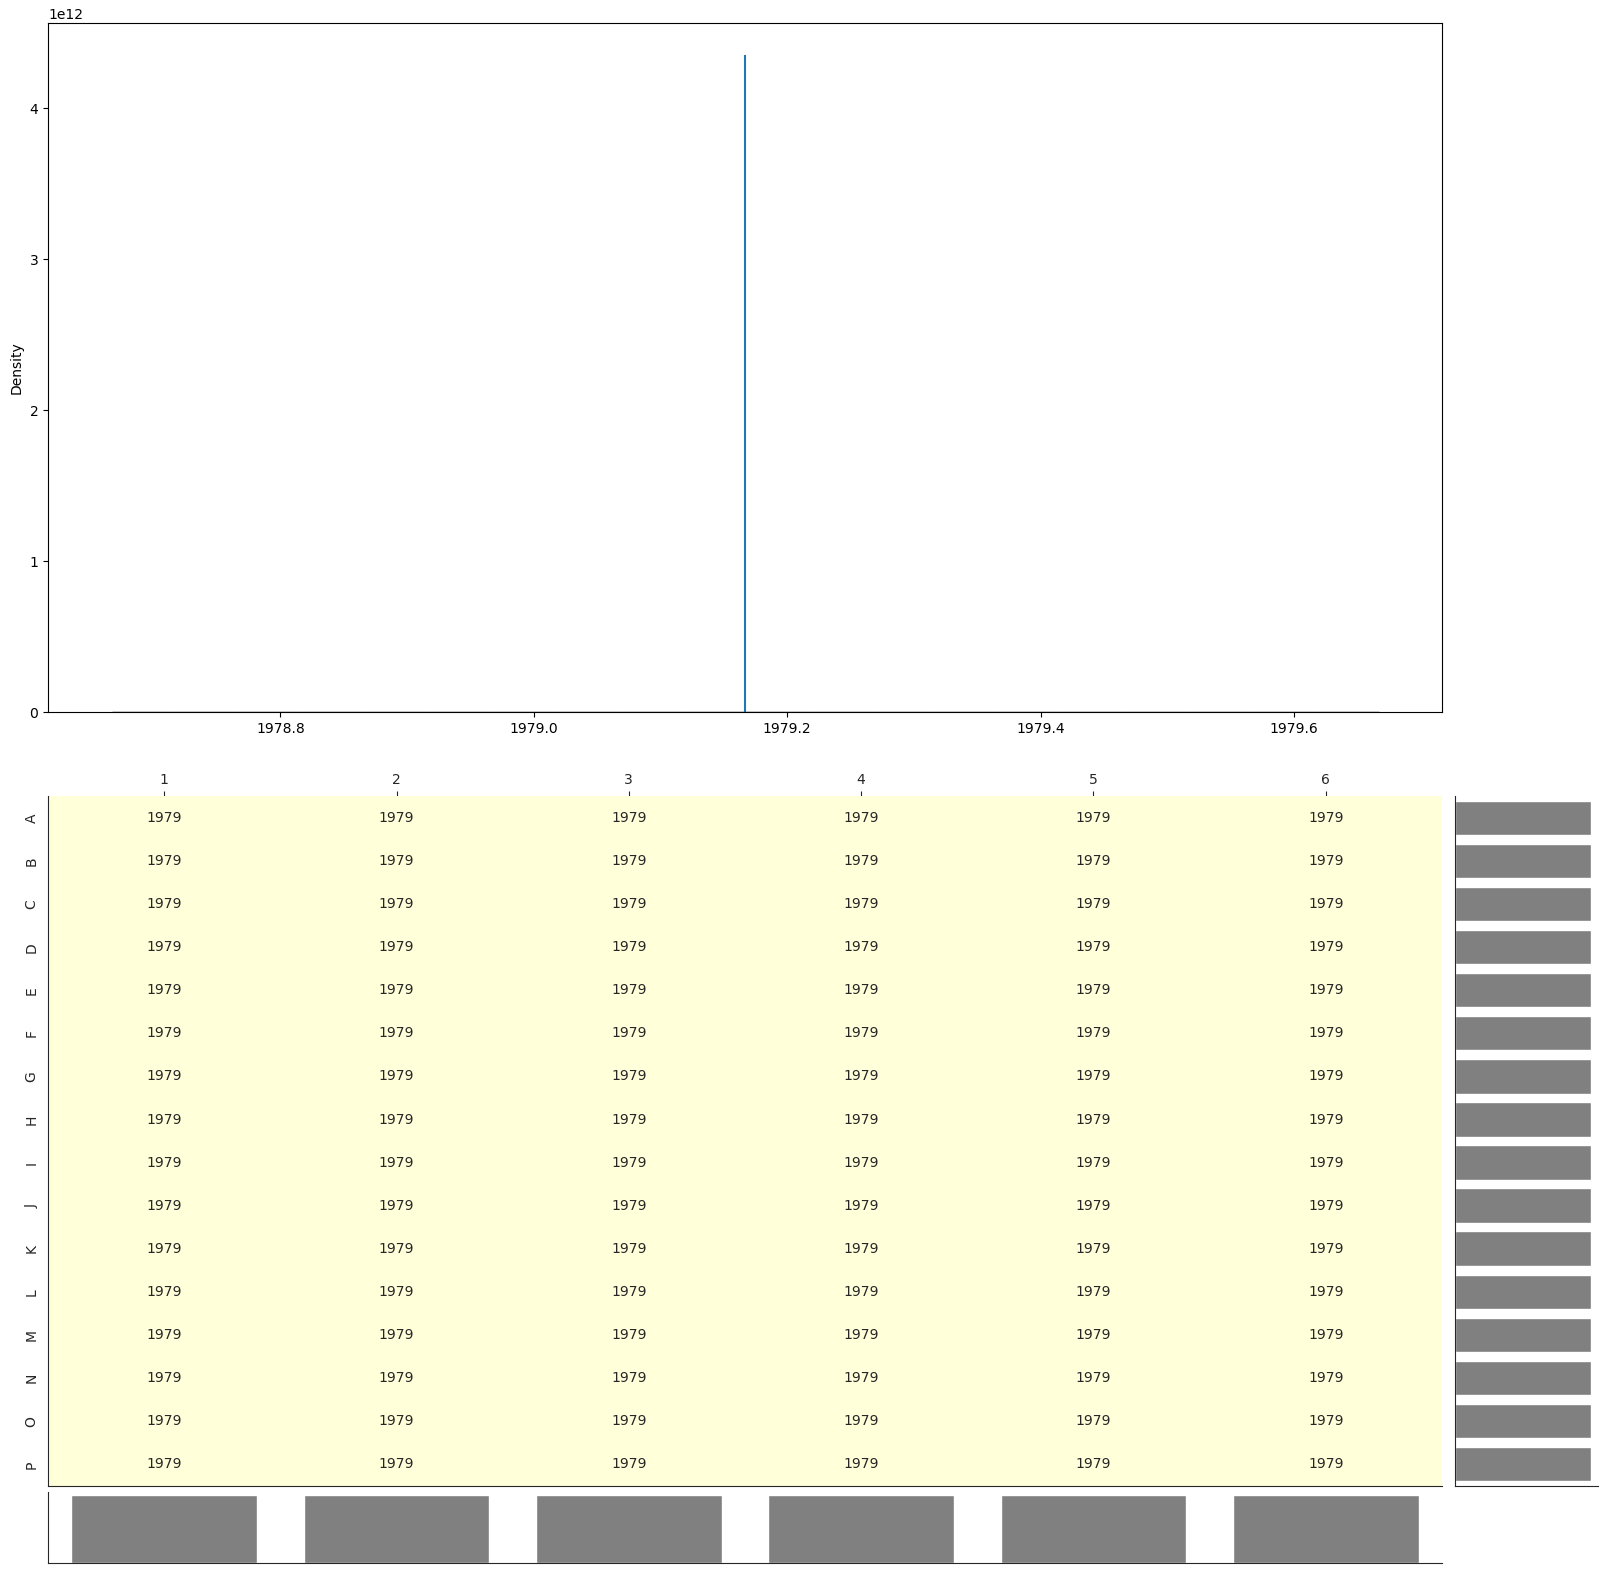

In [23]:
# visualize
print("Floor concentration: {}".format(threshold))
conc, vol = estimate_pool_conc_vol(plate_df[MINIPICO_POOLED_VOL_KEY], plate_df[MINIPICO_LIB_CONC_KEY])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

<Axes: xlabel='MiniPico Library Concentration', ylabel='MiniPico Pooled Volume'>

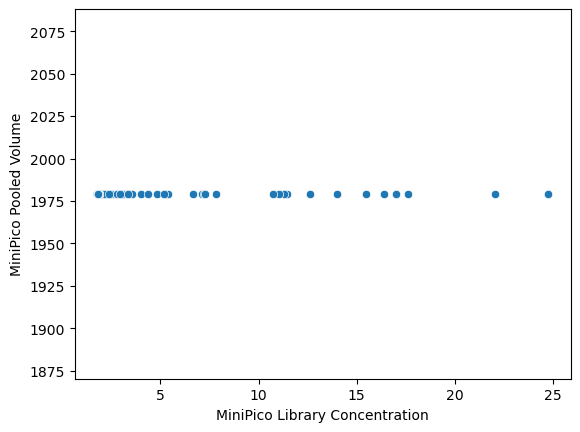

In [24]:
sns.scatterplot(x=MINIPICO_LIB_CONC_KEY, y=MINIPICO_POOLED_VOL_KEY,data=plate_df)

### Step 4 of 7: Make equal volume pooling pick list

In [25]:
## INPUT
evp_picklist_fbase = './test_output/Indices/Tellseq_evp'

In [26]:
evp_picklist = format_pooling_echo_pick_list(
    vols, max_vol_per_well=30000, source_well_names=source_well_names)

In [27]:
evp_picklist_fp = get_set_fp(evp_picklist_fbase, current_set_id)
evp_picklist_fp

'./test_output/Indices/Tellseq_evp_set_col19to24.txt'

In [28]:
warn_if_fp_exists(evp_picklist_fp)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/util.py:174: UserWarning: Warning! This file exists already: ./test_output/Indices/Tellseq_evp_set_col19to24.txt.
  warnings.warn(f"Warning! This file exists already: {fp}.")


In [29]:
with open(evp_picklist_fp,'w') as f:
    f.write(evp_picklist)

!head {evp_picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2,A19,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,A20,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,A21,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,A22,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,A23,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,A24,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,B19,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,B20,,1979.17,NormalizedDNA,A1
1,384LDV_AQ_B2,B21,,1979.17,NormalizedDNA,A1


### Step 5 of 7: Make machine samplesheet for iSeq instrument

In [30]:
## INPUT
machine_samplesheet_fbase = './test_output/SampleSheets/Tellseq_samplesheet_instrument_iseq'

Do not change the below constants unless you really know what you are doing!

In [31]:
MACHINE_SHEET_TEMPLATE = """[Header],,,,,,,,,,,
Experiment Name,{expt_name},,,,,,,,,,
Investigator Name,Enter the investigator name (optional),,,,,,,,,,
Project Name,{proj_name},,,,,,,,,,
Date,{today_date},,,,,,,,,,
Workflow,GenerateFASTQ,,,,,,,,,,
Library Prep Kit,TELLSEQ,,,,,,,,,,
[Manifest],,,,,,,,,,,
Enter the manifest files used to align to targeted reference regions of the genome. Use the following format.,,,,,,,,,,,
ManifestKey, ManifestFile,,,,,,,,,,
[Reads],,,,,,,,,,,
146,,,,,,,,,,,
146,,,,,,,,,,,
[Settings],,,,,,,,,,,
Enter any analysis settings. See the example setting below,,,,,,,,,,,
Adapter, CTGTCTCTTATACACATCT,,,,,,,,,,
[Data],,,,,,,,,,,
Enter sample information for the run in this section,,,,,,,,,,,
Sample_ID,Sample_Name,Sample_Plate,Description,I7_Index_ID,index,I5_Index_ID,index2,Manifest,GenomeFolder,Sample_Project,Sample_Well
Sample1,,A,A1,7027,NNNNNNNNNNNNNNNNNN,5001,NNNNNNNNNN,,,,"""

In [32]:
def make_set_machine_sheet_str(a_plate_df, an_expt_name, a_set_id):
    set_expt_name = f"{an_expt_name}_{a_set_id}"
    # TODO: this is a bit of a hack; you can end up with multiple 
    #  compressed plate names due to multiple dilutions, and there's no 
    #  guarantee that every 96-sample barcode set will happen to pull from all
    #  the same dilution plates as all the others.  But I think it will still
    #  be clear to a human that they all come from the same project.
    compressed_plate_name = \
        sorted(list(a_plate_df[PM_COMPRESSED_PLATE_NAME_KEY].unique()))[0]
    curr_date = datetime.now().strftime('%Y-%m-%d')
    result = MACHINE_SHEET_TEMPLATE.format(
        expt_name=set_expt_name, proj_name=compressed_plate_name, 
        today_date=curr_date)
    return result

In [33]:
machine_sheet_str = make_set_machine_sheet_str(
    plate_df, expt_name, current_set_id)

In [34]:
machine_samplesheet_fp = get_set_fp(machine_samplesheet_fbase, current_set_id)
warn_if_fp_exists(machine_samplesheet_fp)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/util.py:174: UserWarning: Warning! This file exists already: ./test_output/SampleSheets/Tellseq_samplesheet_instrument_iseq_set_col19to24.txt.
  warnings.warn(f"Warning! This file exists already: {fp}.")


In [35]:
with open(machine_samplesheet_fp,'w') as f:
    f.write(machine_sheet_str)
    
!head {machine_samplesheet_fp}

[Header],,,,,,,,,,,
Experiment Name,RKLtest_col19to24,,,,,,,,,,
Investigator Name,Enter the investigator name (optional),,,,,,,,,,
Project Name,Wellcome_Leap_15538_1_2_3_4_10to1dilution,,,,,,,,,,
Date,2024-12-04,,,,,,,,,,
Workflow,GenerateFASTQ,,,,,,,,,,
Library Prep Kit,TELLSEQ,,,,,,,,,,
[Manifest],,,,,,,,,,,
Enter the manifest files used to align to targeted reference regions of the genome. Use the following format.,,,,,,,,,,,
ManifestKey, ManifestFile,,,,,,,,,,


### Step 6 of 7: Make iSeq and NovaSeqX samplesheets for the SPP

In [36]:
## INPUT
spp_samplesheet_fbase = './test_output/SampleSheets/Tellseq_samplesheet_spp'
iseq_sequencer = 'iSeq'
novaseq_sequencer = 'NovaSeqX'

In [37]:
lanes = [1]

In [38]:
# CONSTANTS: Users, DO NOT CHANGE THESE
# values without consulting with tech team
SHEET_TYPE_VERSIONS = {
    TELLSEQ_METAG_SHEET_TYPE: '10',  # version supporting SampleContext
    TELLSEQ_ABSQUANT_SHEET_TYPE: '10'
}

BIOINFO_BASE = {
    'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
    'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
    'library_construction_protocol': 'Knight Lab Kapa HyperPlus',
    # The BarcodesAreRC value is no longer used, but is still checked for
    # by the validation while making the sample sheet, so put in a dummy value
    'BarcodesAreRC': 'True'
}

In [39]:
# Determine the sample sheet type to make
expt_type = TELLSEQ_ABSQUANT_SHEET_TYPE if is_absquant(plate_df) \
    else TELLSEQ_METAG_SHEET_TYPE
expt_type

'tellseq_metag'

In [40]:
# Extend the metadata dictionary with additional information
metadata_dict_w_sample_context = make_sections_dict(
    plate_df, studies_info, expt_name,
    expt_type, SHEET_TYPE_VERSIONS[expt_type], BIOINFO_BASE)

In [41]:
iseq_spp_sheet = make_sample_sheet(
    metadata_dict_w_sample_context, plate_df, iseq_sequencer, lanes)

In [42]:
iseq_spp_samplesheet_fp = get_set_fp(
    f"{spp_samplesheet_fbase}_{iseq_sequencer.lower()}", current_set_id)
warn_if_fp_exists(iseq_spp_samplesheet_fp)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/util.py:174: UserWarning: Warning! This file exists already: ./test_output/SampleSheets/Tellseq_samplesheet_spp_iseq_set_col19to24.txt.
  warnings.warn(f"Warning! This file exists already: {fp}.")


In [43]:
with open(iseq_spp_samplesheet_fp,'w') as f:
    iseq_spp_sheet.write(f)

!head {iseq_spp_samplesheet_fp}

[Header],,,,,,,,
IEMFileVersion,4,,,,,,,
SheetType,tellseq_metag,,,,,,,
SheetVersion,10,,,,,,,
Investigator Name,Knight,,,,,,,
Experiment Name,RKLtest,,,,,,,
Date,2024-12-04,,,,,,,
Workflow,GenerateFASTQ,,,,,,,
Application,FASTQ Only,,,,,,,
Assay,Metagenomic,,,,,,,


In [44]:
novaseq_spp_sheet = make_sample_sheet(
    metadata_dict_w_sample_context, plate_df, novaseq_sequencer, lanes)

In [45]:
novaseq_spp_samplesheet_fp = get_set_fp(
    f"{spp_samplesheet_fbase}_{novaseq_sequencer.lower()}", current_set_id)
warn_if_fp_exists(novaseq_spp_samplesheet_fp)

In [46]:
with open(novaseq_spp_samplesheet_fp,'w') as f:
    novaseq_spp_sheet.write(f)

!head {novaseq_spp_samplesheet_fp}

[Header],,,,,,,,
IEMFileVersion,4,,,,,,,
SheetType,tellseq_metag,,,,,,,
SheetVersion,10,,,,,,,
Investigator Name,Knight,,,,,,,
Experiment Name,RKLtest,,,,,,,
Date,2024-12-04,,,,,,,
Workflow,GenerateFASTQ,,,,,,,
Application,FASTQ Only,,,,,,,
Assay,Metagenomic,,,,,,,


### Step 7 of 7: Write plate set dataframe to file

Save the plate dataframe for this set containing the pooled volume results.

In [47]:
plate_set_fbase = full_plate_fp.replace("B.txt", f"C")
plate_set_fp = get_set_fp(plate_set_fbase, current_set_id)
plate_set_fp

'./test_output/QC/Tellseq_plate_df_C_set_col19to24.txt'

In [48]:
warn_if_fp_exists(plate_set_fp)

In [49]:
plate_df.to_csv(plate_set_fp, sep="\t", index=False)